# Uso do gerador de sinais nos classificadores desenvolvidos
## Grupo 2 - Trabalho de Conclusão de Curso
### - Bruno Uchôa Brandão e Silva - 12412440
### - Rayan Luz Ralile - 12412502

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch
import scipy.signal

import numpy as np
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import re
import base64
from cryptography.fernet import Fernet
from IPython.core.display import HTML

import calendar
import time

2023-11-14 19:46:54.031178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Agora a modelagem do sinal acústico seguindo metodologia do artigo de Wittekind

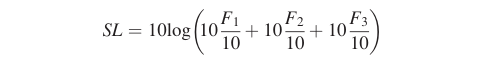

In [2]:
def sourceLevel(F1, F2, F3):
    SL = 10 * np.log10(10**(F1/10) + 10**(F2/10) + 10**(F3/10))
    SL = float(SL)
    return SL

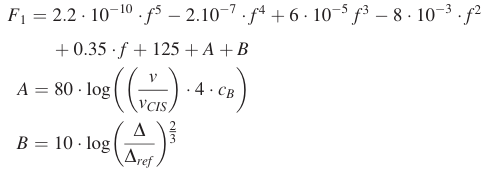
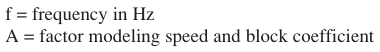
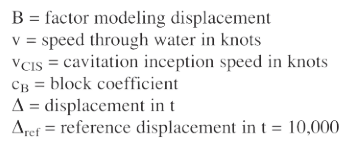

In [3]:
def calcA(v,v_cis,cb):
    A = 80*np.log10((v/v_cis)*4*cb)
    return float(A)

In [4]:
# Função validada
def calcB(displacement,displacement_ref=10000):
    B = 10*np.log10((displacement/displacement_ref)**(2/3))
    return float(B)

In [5]:
# Função validada
def calcF1(f,A,B):
    F1 = 2.2*10**(-10)*f**5 - 2*10**(-7)*f**4 + 6*10**(-5)*f**3 - 8*10**(-3)*f**2 + 0.35*f + 125 + A + B
    return float(F1)

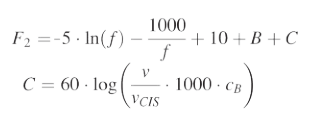

In [6]:
# Validado
def calcC(v,v_cis,cb):
    C = 60*np.log10((v/v_cis)*1000*cb)
    return float(C)

In [7]:
# Validado!
def calcF2(f,B,C):
    F2 = -5*np.log(f)-(1000/f) + 10 + B + C
    return float(F2)

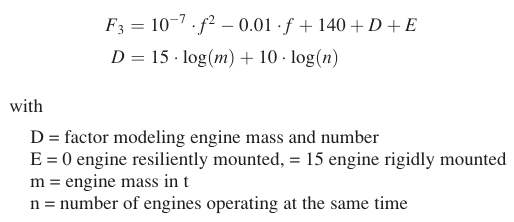

In [8]:
# validado
def calcD(m,n):
    D = 15*np.log10(m) + 10*np.log10(n)
    return float(D)

In [9]:
# validado
def calcF3(f,D,E = 0):
    F3 = 10**(-7)*f**2 - 0.01*f + 140 + D + E
    return float(F3)

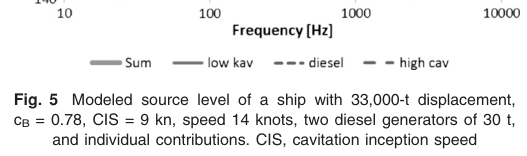

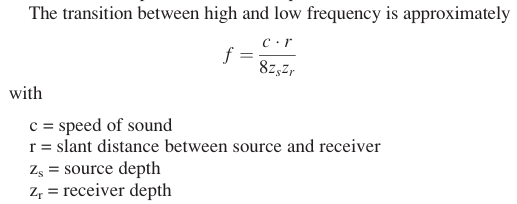

In [10]:
# Frequência de "corte"
def calcCorteFreq(c,r,z_s,z_r):
    fcorte = (c*r)/(8*z_s*z_r)
    return float(fcorte)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


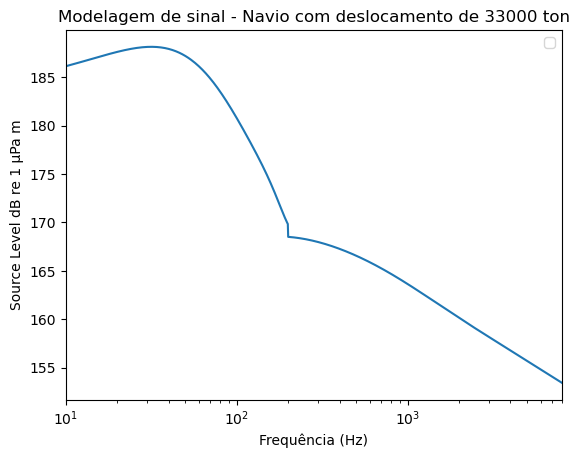

In [11]:
A = calcA(14,9,0.78) #v, v_cis and cb
B = calcB(33000,10000) # displacement and displacement reference
C = calcC(14,9,0.78)#v, v_cis and cb
D = calcD(30,2) #mass in ton of propulser and n number of props
E = 0
f = 1000


vectorSL = []

for f in range(10, 8001):  # Intervalo de frequência de 10 a 8000 Hz
    if f < 200:
        F1 = calcF1(f, A, B)
    else:
        F1 = 0
    F2 = calcF2(f, B, C)
    F3 = calcF3(f, D, E)
    SL = sourceLevel(F1, F2, F3)
    vectorSL.append(SL)

f = range(10, 8001)

plt.plot(f, vectorSL)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Source Level dB re 1 µPa m')
plt.title('Modelagem de sinal - Navio com deslocamento de 33000 ton')
plt.xscale('log')
plt.xlim(10, 8000)  # Limites do eixo x ajustados para 10 a 8000 Hz
plt.legend()
plt.show()

### Este plot está de acordo com o artigo de Wittekind:

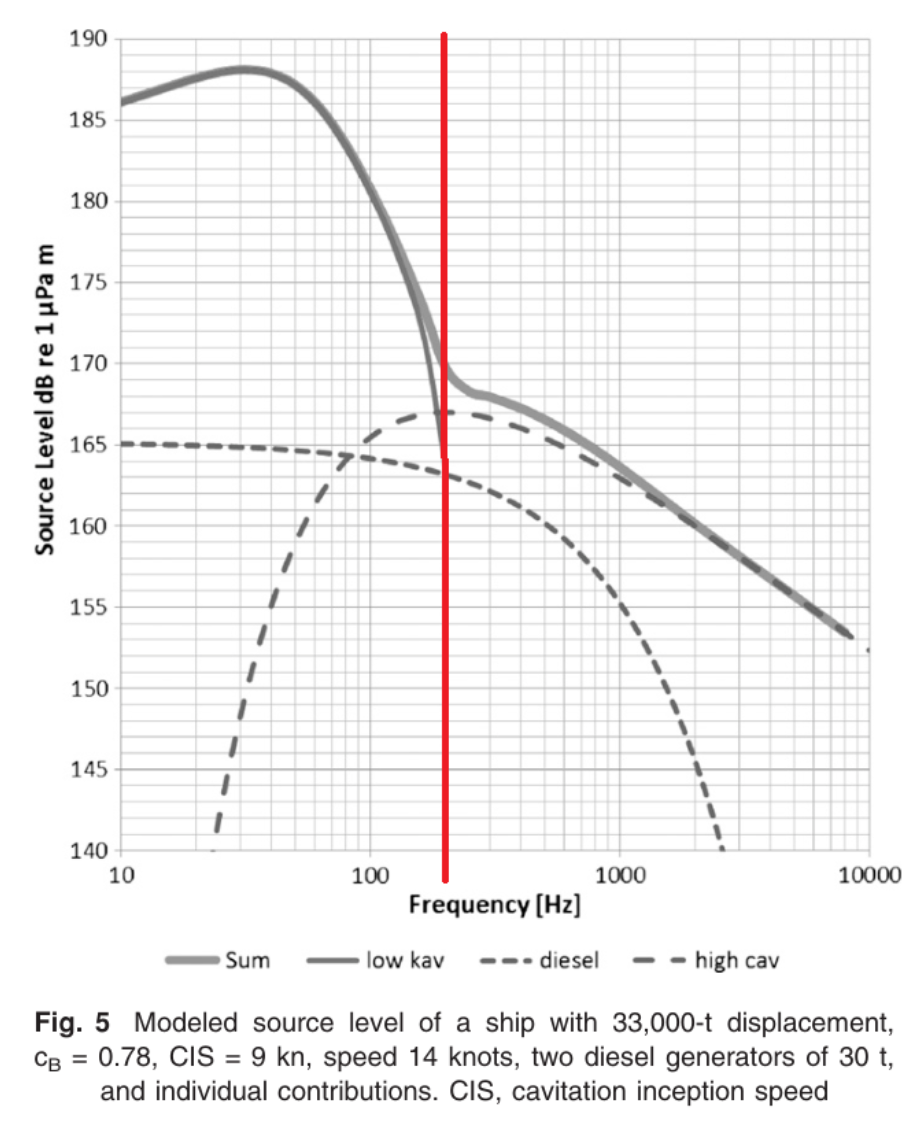

### Agora ocorrerá o tratamento desse sinal gerado para aplicar o mesmo DataPrep feito nos arquivos .wav, ou seja, obter os bins de frequência pelo método de Welch e normalizar os dados (de 10 em 10Hz até 2000):

In [12]:
def process_signal_data(frequencies, SL_values, sample_rate=4800):
    scaler = MinMaxScaler()

    # Método Welch para obter os bins de frequência
    freqs, psd = welch(SL_values, sample_rate, nperseg=480, noverlap=240)
    
    #psd_list = []

    # Seleciona apenas as frequências de interesse
    psd = psd[(freqs >= 10) & (freqs <= 2000)]
    #psd_list.append(psd)
    
    #result = np.array(psd_list)
    #samples = []
    #samples.extend(result)
    #samples = np.array(samples)
    # Normalização
    #scaler = MinMaxScaler()
    #samples = scaler.fit_transform(samples)

    # Normalização
    psd_normalized = scaler.fit_transform(psd.reshape(-1, 1)).flatten()

    return psd_normalized

In [13]:
sample = process_signal_data(f, vectorSL)

In [14]:
samples = []
samples.append(sample)
samples = np.array(samples)

len(samples)

1

### Definição de funções auxiliares

In [15]:
def create_plot(classificados, plot_name = "default.svg"):
   # Plotagem dos resultados
    classifications = classificados
    grande = 0
    pequeno = 0
    for classif in classifications:
        if classif == 'Navio Grande Porte' or classif == 'Grande Porte' or classif == 0:
            grande += 1
        if classif == 'Navio Pequeno Porte' or classif == 'Pequeno Porte' or classif == 1:
            pequeno += 1
    # plotagem da pizza
    labels = ['Navio Grande Porte', 'Navio Pequeno Porte']
    sizes = [grande, pequeno]

    colors = ['#ff9999','#66b3ff']


    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Círculo branco central pra fazer a cara da pizza
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)


    ax1.axis('equal')  
    plt.tight_layout()


    plt.savefig("output.png", format='png')
    plt.savefig(plot_name, format='svg')

    # Agora o veredito:
    total = grande + pequeno
    if grande > pequeno and (grande/total) >= 0.6:
        return "Navio de Grande Porte"
    elif pequeno > grande and (pequeno/total) >= 0.6:
        return "Navio de Pequeno Porte"
    else:
        return "Inconclusivo"

In [16]:
# Funções de salvar e carregar objetos diversos - otimizar os passos de tratamento do dataset e treino
def salva_objeto(obj, file_path = "data.pickle"):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def carrega_objeto(file_path = "data.pickle"):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj

### Aplicar o MLP do Keras para distinguir se o sinal é Navio ou Baleia

2023-11-14 19:46:56.963469: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 0s 91ms/step
Navio = 1
Baleia = 0


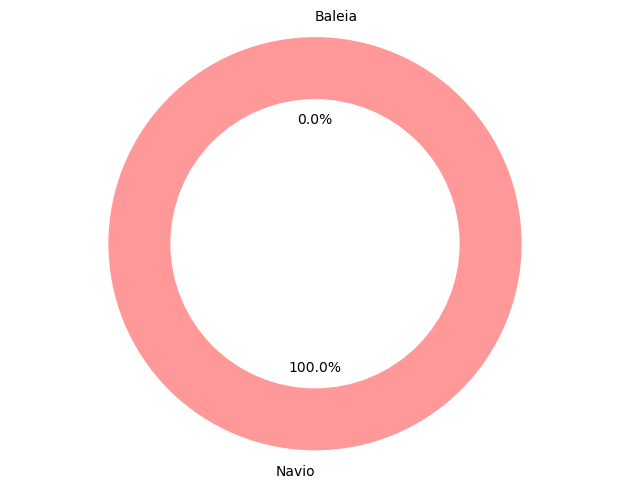

In [17]:
# Carrega o modelo de Rede Neural para distinção Navio vs Baleia
model = keras.models.load_model('modelBaleiasNavios2.h5')

classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade

# Agora temos a variável final_decision que vai guardar a classificação final e será usado
# para mostrar o veredito de classificação ao usuário

final_decision = ''

# Aqui os pontos classificados serão contabilizados para a decisão entre navios ou baleias

qtd_navios = 0
qtd_baleias = 0
for classif in predicted_labels:
    if classif == 'Navio' or classif == 0:
        qtd_navios += 1
    if classif == 'Baleia' or classif == 1:
        qtd_baleias += 1
        
print(f'Navio = {qtd_navios}')
print(f'Baleia = {qtd_baleias}')

if (qtd_baleias/(qtd_navios+qtd_baleias)) >= 0.6:
    final_decision = "Baleia"
elif (qtd_baleias/(qtd_navios+qtd_baleias)) > 0.4:
    final_decision = "Não identificado"
else:
    final_decision = "Navio"
    
# plotagem da pizza
labels = ['Navio', 'Baleia']
sizes = [qtd_navios, qtd_baleias]

colors = ['#ff9999','#66b3ff']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Círculo branco central pra fazer a cara da pizza
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()


# Salva o plot com timestamp
current_GMT = time.gmtime()
time_stamp = calendar.timegm(current_GMT)

plt.savefig(f'NavBaleia - {time_stamp}', format='svg')
        
plt.show()

### Agora aplicar o sinal gerado nos três classificadores para averiguar o porte de navio do sinal gerado por modelagem

### * Classificador Indutivo ID3:

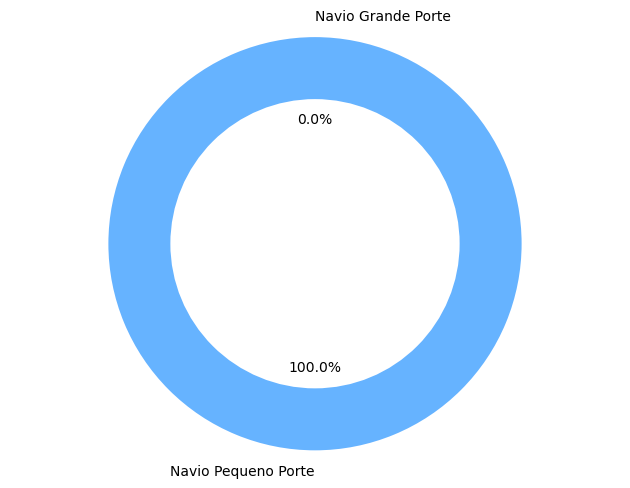

In [18]:
class TreeNode:
    def __init__(self, label, error):
        self.label = label
        self.error = error
        self.left = None
        self.right = None
        self.condition = None

def ID3_classifier(samples, file_path = 'Inducer.dot', safe = False, key_path = None):
    def parse_dot(dot_string):
        # Extrai as definições de nós e relacionamentos
        node_defs = re.findall(r'node_(\d+) \[label="([^"]+)"\]', dot_string)
        edges = re.findall(r'node_(\d+)->node_(\d+) \[label="([^"]+)"\]', dot_string)
        
        nodes = {}
        
        # Extrai o label do nó e o erro de cada definiçãoe cria o TreeNode
        for node_def in node_defs:
            node_id, label_error = node_def
            split_label = label_error.split('\\n')
            
            if len(split_label) == 2:
                label, error = split_label
            else:
                label = split_label[0]
                error = None
            
            nodes[node_id] = TreeNode(label, error)

        # Extrai origem, destino, e condição para cada nó e sua ligação
        for edge in edges:
            src_id, tgt_id, label = edge
            if label.startswith('<='):
                nodes[src_id].left = nodes[tgt_id]
                nodes[src_id].condition = float(re.search(r'<= ([\d.]+)', label).group(1))
            else:
                nodes[src_id].right = nodes[tgt_id]

        return nodes['0']

    if safe: # quer dizer que deve aplicar a decodificação
        with open(key_path, 'rb') as key_file:
                key = key_file.read()
        cipher = Fernet(key)
        with open(file_path, 'rb') as file:
            encrypted_data = file.read()

        decrypted_data = cipher.decrypt(encrypted_data)
        # Abaixo se eu desejar escrever o arquivo decifrado
        #with open(output_file_name, 'wb') as file:
        #    file.write(decrypted_data)
        dot_content = decrypted_data.decode('utf-8')
    else:
        with open(file_path, 'r') as file:
                dot_content = file.read()

    #print(dot_content) - fins de debug
    root = parse_dot(dot_content)

    #print(root.label) - fins de debug
    #print(root.left.label) 
    #print(root.right.label) 

    def classificador(root, dicionario):
        #self.root = root # Recebe o nó raíz da árvore com toda ela construída
        #self.dicionario = dicionario # recebe dicionário onde chave é a frequência e valor é o psd
        # Agora o processamento para chegar na classificação

        pointer = root
        while(pointer.condition):
            if dicionario[pointer.label] <= pointer.condition:
                pointer = pointer.left
            else:
                pointer = pointer.right

        classif = pointer.label
        return classif

    classificacoes = []
    for ponto in samples:
        frequency_keys = [f"{i}Hz" for i in range(10, 2010, 10)]
        data_dictionary = {key: value for key, value in zip(frequency_keys, ponto)}
        classificacoes.append(classificador(root, data_dictionary))

    return classificacoes

# inicialmente temos que multiplicar os valores adquiridos por fator constante para uso do ID3
# conforme configurado anteriormente

resultID3 = samples * 100000000

# Agora o código abaixo irá fazer a leitura do arquivo .rbf junto com sua chave para montar em memória a
# árvore binária de decisão advinda do treino do algoritmo indutivo

classificacoes = ID3_classifier(samples=resultID3,file_path='indutivo.rbf',safe=True,key_path='tcc.key')

# O create_plot executa a análise dos pontos já classificados, atribui veredito
# e mostra gráfico de pizza com os resultados.
final_decision = create_plot(classificacoes,"ID3.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### Agora com MLP do Keras

1/1 [==============================] - 0s 41ms/step


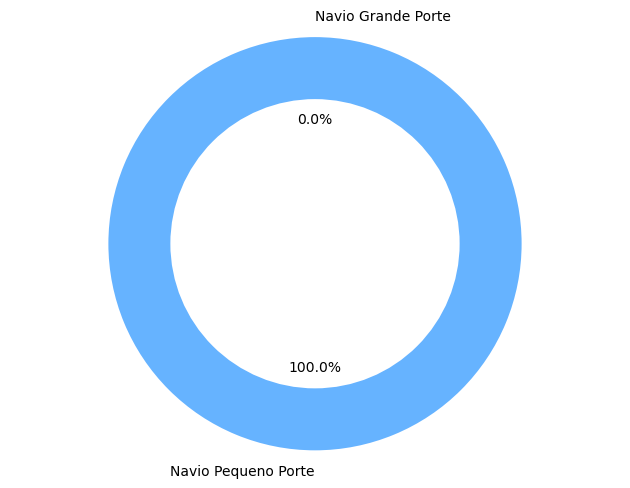

In [19]:
model = load_model("modelKeras.h5")
# Predição com Keras
classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade


final_decision = create_plot(predicted_labels,"kerasMLP.svg") # Cria o plot, salva em imagem svg e no output.png

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### Agora com MLP do Scikit-Learn

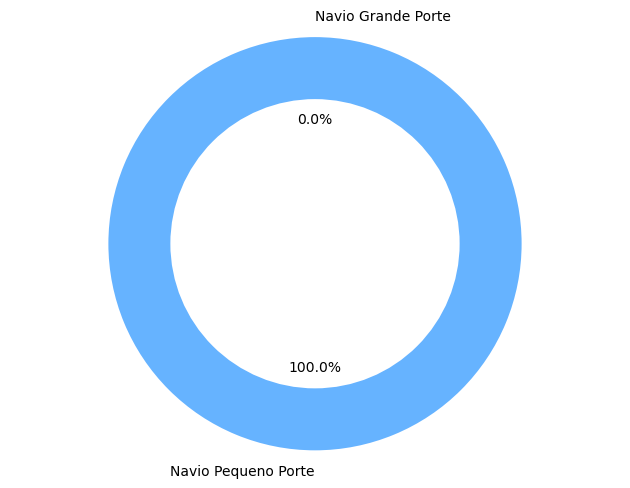

In [20]:
mlp = carrega_objeto("scikitmlp.pkl")

classifications = mlp.predict(samples)

final_decision = create_plot(classifications,"scikit-learnMLP.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### Agora a modelagem de sinal acústico de outra embarcação - maior que a primeira

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


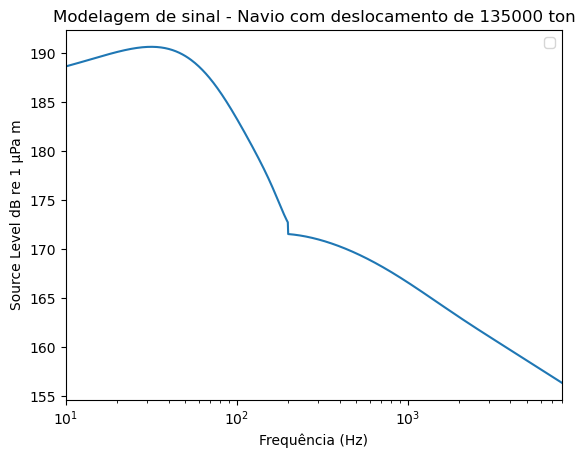

In [21]:
A = calcA(25,14,0.65) #v, v_cis and cb
B = calcB(135000,10000) # displacement and displacement reference
C = calcC(25,14,0.65)#v, v_cis and cb
D = calcD(50,2) #mass in ton of propulser and n number of props
E = 0
f = 1000


vectorSL2 = []

for f in range(10, 8001):  # Intervalo de frequência de 10 a 8000 Hz
    if f < 200:
        F1 = calcF1(f, A, B)
    else:
        F1 = 0
    F2 = calcF2(f, B, C)
    F3 = calcF3(f, D, E)
    SL = sourceLevel(F1, F2, F3)
    vectorSL2.append(SL)

f = range(10, 8001)

plt.plot(f, vectorSL2)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Source Level dB re 1 µPa m')
plt.title('Modelagem de sinal - Navio com deslocamento de 135000 ton')
plt.xscale('log')
plt.xlim(10, 8000)  # Limites do eixo x ajustados para 10 a 8000 Hz
plt.legend()
plt.show()

### Foi utilizada a velocidade de 25 nós. O resultado da simulação está de acordo com o artigo de Wittekind:

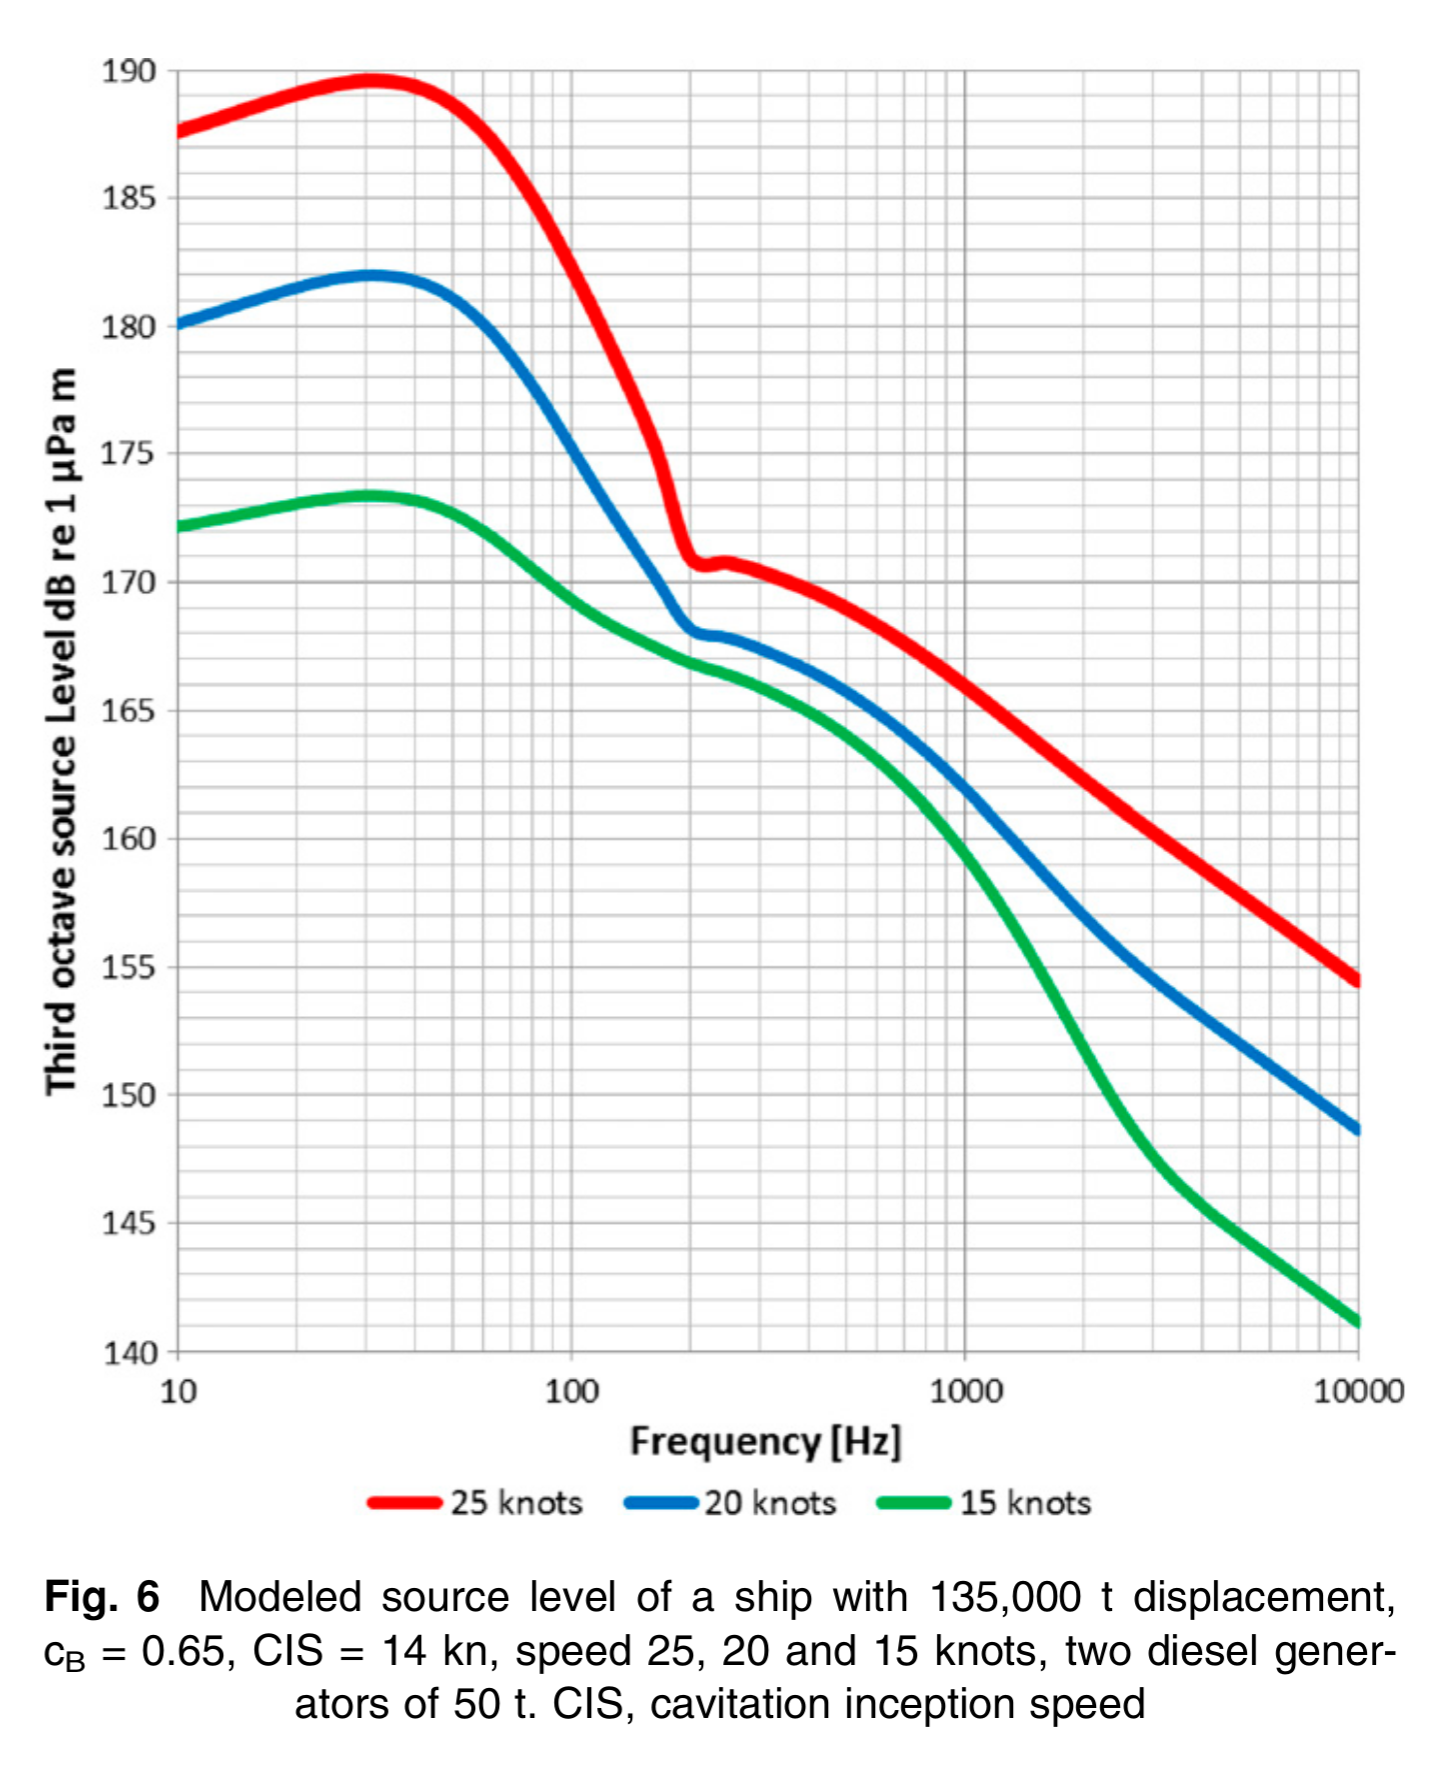

### Realizando DataPrep e aplicando ruído branco para simular captação

In [22]:
sample2 = process_signal_data(f, vectorSL2)
samples = []
samples.append(sample2)
samples = np.array(samples)

### Analisando sinal gerado para ver se é baleia ou navio com MLP do Keras

1/1 [==============================] - 0s 39ms/step
Navio = 1
Baleia = 0


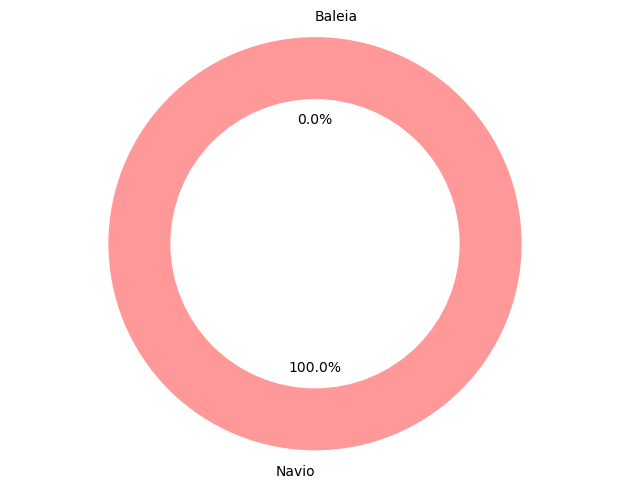

In [23]:
# Carrega o modelo de Rede Neural para distinção Navio vs Baleia
model = keras.models.load_model('modelBaleiasNavios2.h5')

classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade

# Agora temos a variável final_decision que vai guardar a classificação final e será usado
# para mostrar o veredito de classificação ao usuário

final_decision = ''

# Aqui os pontos classificados serão contabilizados para a decisão entre navios ou baleias

qtd_navios = 0
qtd_baleias = 0
for classif in predicted_labels:
    if classif == 'Navio' or classif == 0:
        qtd_navios += 1
    if classif == 'Baleia' or classif == 1:
        qtd_baleias += 1
        
print(f'Navio = {qtd_navios}')
print(f'Baleia = {qtd_baleias}')

if (qtd_baleias/(qtd_navios+qtd_baleias)) >= 0.6:
    final_decision = "Baleia"
elif (qtd_baleias/(qtd_navios+qtd_baleias)) > 0.4:
    final_decision = "Não identificado"
else:
    final_decision = "Navio"
    
# plotagem da pizza
labels = ['Navio', 'Baleia']
sizes = [qtd_navios, qtd_baleias]

colors = ['#ff9999','#66b3ff']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Círculo branco central pra fazer a cara da pizza
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


ax1.axis('equal')  
plt.tight_layout()


# Salva o plot com timestamp
current_GMT = time.gmtime()
time_stamp = calendar.timegm(current_GMT)

plt.savefig(f'NavBaleia - {time_stamp}', format='svg')
        
plt.show()

### Agora o classificador indutivo ID3

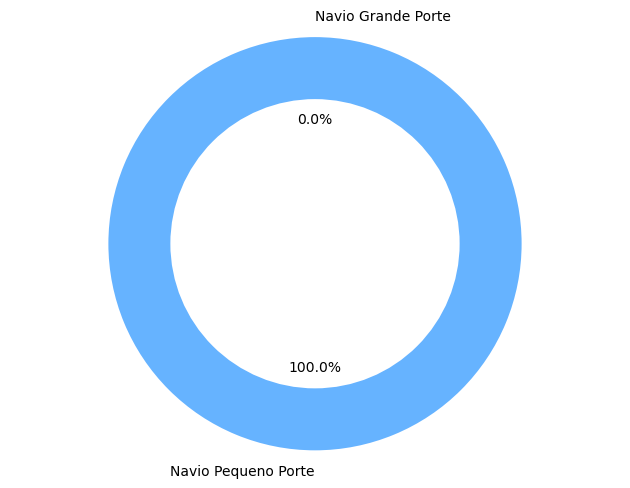

In [24]:
class TreeNode:
    def __init__(self, label, error):
        self.label = label
        self.error = error
        self.left = None
        self.right = None
        self.condition = None

def ID3_classifier(samples, file_path = 'Inducer.dot', safe = False, key_path = None):
    def parse_dot(dot_string):
        # Extrai as definições de nós e relacionamentos
        node_defs = re.findall(r'node_(\d+) \[label="([^"]+)"\]', dot_string)
        edges = re.findall(r'node_(\d+)->node_(\d+) \[label="([^"]+)"\]', dot_string)
        
        nodes = {}
        
        # Extrai o label do nó e o erro de cada definiçãoe cria o TreeNode
        for node_def in node_defs:
            node_id, label_error = node_def
            split_label = label_error.split('\\n')
            
            if len(split_label) == 2:
                label, error = split_label
            else:
                label = split_label[0]
                error = None
            
            nodes[node_id] = TreeNode(label, error)

        # Extrai origem, destino, e condição para cada nó e sua ligação
        for edge in edges:
            src_id, tgt_id, label = edge
            if label.startswith('<='):
                nodes[src_id].left = nodes[tgt_id]
                nodes[src_id].condition = float(re.search(r'<= ([\d.]+)', label).group(1))
            else:
                nodes[src_id].right = nodes[tgt_id]

        return nodes['0']

    if safe: # quer dizer que deve aplicar a decodificação
        with open(key_path, 'rb') as key_file:
                key = key_file.read()
        cipher = Fernet(key)
        with open(file_path, 'rb') as file:
            encrypted_data = file.read()

        decrypted_data = cipher.decrypt(encrypted_data)
        # Abaixo se eu desejar escrever o arquivo decifrado
        #with open(output_file_name, 'wb') as file:
        #    file.write(decrypted_data)
        dot_content = decrypted_data.decode('utf-8')
    else:
        with open(file_path, 'r') as file:
                dot_content = file.read()

    #print(dot_content) - fins de debug
    root = parse_dot(dot_content)

    #print(root.label) - fins de debug
    #print(root.left.label) 
    #print(root.right.label) 

    def classificador(root, dicionario):
        #self.root = root # Recebe o nó raíz da árvore com toda ela construída
        #self.dicionario = dicionario # recebe dicionário onde chave é a frequência e valor é o psd
        # Agora o processamento para chegar na classificação

        pointer = root
        while(pointer.condition):
            if dicionario[pointer.label] <= pointer.condition:
                pointer = pointer.left
            else:
                pointer = pointer.right

        classif = pointer.label
        return classif

    classificacoes = []
    for ponto in samples:
        frequency_keys = [f"{i}Hz" for i in range(10, 2010, 10)]
        data_dictionary = {key: value for key, value in zip(frequency_keys, ponto)}
        classificacoes.append(classificador(root, data_dictionary))

    return classificacoes

# inicialmente temos que multiplicar os valores adquiridos por fator constante para uso do ID3
# conforme configurado anteriormente

resultID3 = samples * 100000000

# Agora o código abaixo irá fazer a leitura do arquivo .rbf junto com sua chave para montar em memória a
# árvore binária de decisão advinda do treino do algoritmo indutivo

classificacoes = ID3_classifier(samples=resultID3,file_path='indutivo.rbf',safe=True,key_path='tcc.key')

# O create_plot executa a análise dos pontos já classificados, atribui veredito
# e mostra gráfico de pizza com os resultados.
final_decision = create_plot(classificacoes,"ID3.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### Usando MLP do Keras para verificar o porte

1/1 [==============================] - 0s 57ms/step


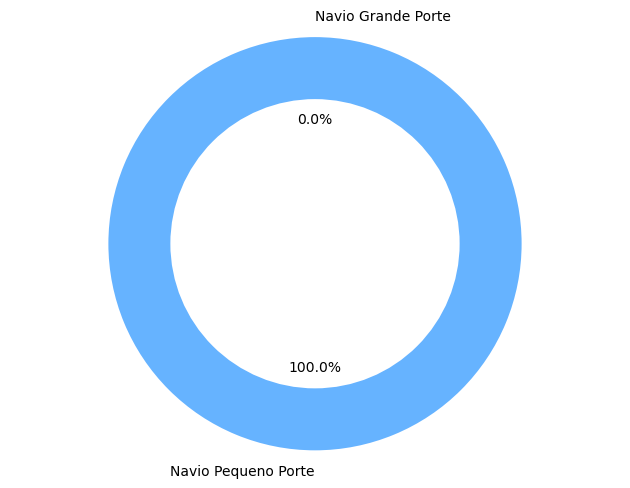

In [25]:
model = load_model("modelKeras.h5")
# Predição com Keras
classifications = model.predict(samples) # executa a predição
predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade


final_decision = create_plot(predicted_labels,"kerasMLP.svg") # Cria o plot, salva em imagem svg e no output.png

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

### Usando o MLP do Scikit-Learn

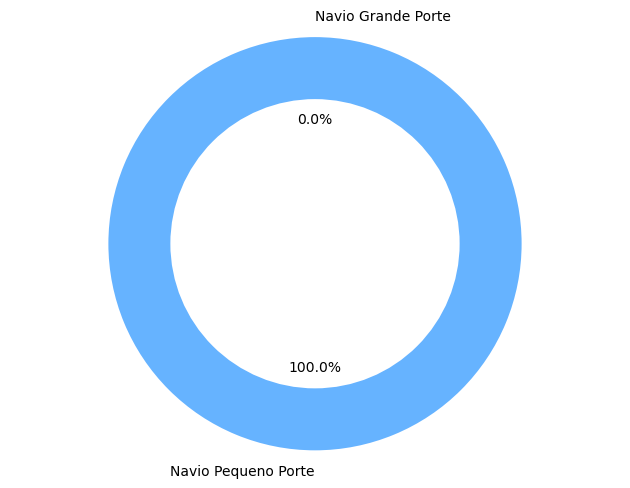

In [26]:
mlp = carrega_objeto("scikitmlp.pkl")

classifications = mlp.predict(samples)

final_decision = create_plot(classifications,"scikit-learnMLP.svg")

HTML(f"""
<div class="alert">
  <p>VEREDITO: {final_decision}.</p>
</div>"""+
"""
<style>
.alert {
  padding: 20px;
  background-color: #f44336;
  color: white;
  margin-bottom: 15px;
}
</style>
""")

# Conclusão

* Apenas a distinção entre Navio e Baleia é capaz de acertar a classificação de um sinal modelado. Isso é um indicativo de que o aprendizado de máquina absorveu em seu aprendizado grande quantidade de informações dos ruídos que fazem parte da natureza marinha e mesmo assim obtém sucesso com dados reais capturados de hidrofones.